# Recommendation System

## Business Understanding

For our final project, we have decided to create a custom recommendation system. The data chosen for training/testing came from the [Million Song Dataset Challenge](https://www.kaggle.com/c/msdchallenge#description). The dataset was originally provided by The Echo Nest and made available by [Columbia University](https://labrosa.ee.columbia.edu/millionsong/) with the puprose encouraging research in machine learning. With this dataset, we will attempt to predict which song a user will want to listen to next.

## Data Understanding

Importing the datasets:

In [1]:
%%capture

import graphlab as gl
import graphlab.aggregate as agg
from matplotlib import pyplot as plt
usage_data = gl.SFrame.read_csv("../data/kaggle_visible_evaluation_triplets.txt",
                                header=False,
                                delimiter='\t',
                                column_type_hints={'X3':int})

songs = gl.SFrame.read_csv("../data/song_data.csv")

Change data labels to be human readable

In [2]:
%%capture
print(usage_data.rename({'X1':'user', 'X2': 'song_id', 'X3': 'plays'}))

Two datasets are included. The first one (`10000.txt`) has three fields: `user`, `song`, `plays` and describes how many times (`play`) a `song` is listened to by a `user`.

There are 1,000,000 songs and 807,216 records of how many times a user has played a song.

In [3]:
usage_data.head()

user,song_id,plays
fd50c4007b68a3737fe052d5a4f78ce8aa117f3d ...,SOBONKR12A58A7A7E0,1
fd50c4007b68a3737fe052d5a4f78ce8aa117f3d ...,SOEGIYH12A6D4FC0E3,1
fd50c4007b68a3737fe052d5a4f78ce8aa117f3d ...,SOFLJQZ12A6D4FADA6,1
fd50c4007b68a3737fe052d5a4f78ce8aa117f3d ...,SOHTKMO12AB01843B0,1
fd50c4007b68a3737fe052d5a4f78ce8aa117f3d ...,SODQZCY12A6D4F9D11,1
fd50c4007b68a3737fe052d5a4f78ce8aa117f3d ...,SOXLOQG12AF72A2D55,1
d7083f5e1d50c264277d624340edaaf3dc16095b ...,SOUVUHC12A67020E3B,1
d7083f5e1d50c264277d624340edaaf3dc16095b ...,SOUQERE12A58A75633,1
d7083f5e1d50c264277d624340edaaf3dc16095b ...,SOIPJAX12A8C141A2D,1
d7083f5e1d50c264277d624340edaaf3dc16095b ...,SOEFCDJ12AB0185FA0,2


There is a second dataset which provides additional information for each songs

In [4]:
songs.head()

song_id,title,release,artist_name,year
SOQMMHC12AB0180CB8,Silent Night,Monster Ballads X-Mas,Faster Pussy cat,2003
SOVFVAK12A8C1350D9,Tanssi vaan,Karkuteillä,Karkkiautomaatti,1995
SOGTUKN12AB017F4F1,No One Could Ever,Butter,Hudson Mohawke,2006
SOBNYVR12A8C13558C,Si Vos Querés,De Culo,Yerba Brava,2003
SOHSBXH12A8C13B0DF,Tangle Of Aspens,Rene Ablaze PresentsWinter Sessions ...,Der Mystic,0
SOZVAPQ12A8C13B63C,"Symphony No. 1 G minor""Sinfonie ...",Berwald: Symphonies Nos.1/2/3/4 ...,David Montgomery,0
SOQVRHI12A6D4FB2D7,We Have Got Love,Strictly The Best Vol. 34,Sasha / Turbulence,0
SOEYRFT12AB018936C,2 Da Beat Ch'yall,Da Bomb,Kris Kross,1993
SOPMIYT12A6D4F851E,Goodbye,Danny Boy,Joseph Locke,0
SOJCFMH12A8C13B0C2,Mama_ mama can't you see? ...,March to cadence with theUS marines ...,The Sun Harbor's Chorus-Documentary Recordings ...,0


It would be nice if our `usage_data` records included relevent information to the song played. So, we will do a merge on the `usage_data` and `songs` datasets so that we can know which songs are actually being played.

In [5]:
ud_df = usage_data.to_dataframe()
song_df = songs.to_dataframe()

new_df = ud_df.merge(song_df, how='left', left_on='song_id', right_on='song_id')

combo_songs = gl.SFrame(new_df)
combo_songs['user', 'title', 'artist_name', 'plays'].head

<bound method SFrame.head of Columns:
	user	str
	title	str
	artist_name	str
	plays	int

Rows: 1491952

Data:
+-------------------------------+-------------------------------+
|              user             |             title             |
+-------------------------------+-------------------------------+
| fd50c4007b68a3737fe052d5a4... |         You're The One        |
| fd50c4007b68a3737fe052d5a4... | Horn Concerto No. 4 in E f... |
| fd50c4007b68a3737fe052d5a4... |            Tive Sim           |
| fd50c4007b68a3737fe052d5a4... | Catch You Baby (Steve Pitr... |
| fd50c4007b68a3737fe052d5a4... |          El Cuatrero          |
| fd50c4007b68a3737fe052d5a4... | Unite (2009 Digital Remaster) |
| d7083f5e1d50c264277d624340... |           Lift Me Up          |
| d7083f5e1d50c264277d624340... |        Living In A Lie        |
| d7083f5e1d50c264277d624340... |         Open Your Eyes        |
| d7083f5e1d50c264277d624340... |           Kurtizana           |
+-------------------------------+

Collaborative filtering based on song and user is the primary objective.  In addition, the user and artist data will be analyzed in the same fashion to determine the preferred method.   Both models will be trained, tested, and compared.  

In [7]:
df_artist = new_df.groupby(by=['user','artist_name'])[['plays']].sum().reset_index()
df_artist.head()

artist = gl.SFrame(df_artist)
artist.head

<bound method SFrame.head of Columns:
	user	str
	artist_name	str
	plays	int

Rows: 1133382

Data:
+-------------------------------+--------------------------------+-------+
|              user             |          artist_name           | plays |
+-------------------------------+--------------------------------+-------+
| 00007a02388c208ea7176479f6... |             Dredg              |   3   |
| 00007a02388c208ea7176479f6... |            Local H             |   1   |
| 00007a02388c208ea7176479f6... |              M83               |   2   |
| 00007a02388c208ea7176479f6... |            No Doubt            |   1   |
| 00007a02388c208ea7176479f6... |            Pantera             |   1   |
| 00007a02388c208ea7176479f6... |           Sam Sparro           |   2   |
| 00007a02388c208ea7176479f6... |      Stone Temple Pilots       |   3   |
| 00014a76ed063e1a749171a253... |      Angels and Airwaves       |   4   |
| 00014a76ed063e1a749171a253... |           Moodymann            |   2   |
| 

### Data Visualization

The dataset being utilized for the project is significant in size.   Due to the size, the visuals can be challenging to present.  To provide an image of the number of songs and the number of plays, each entry was categorized based on the number of plays.  The pie chart below shows the percentage of songs in each category.   

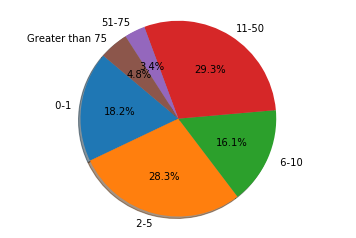

In [8]:
#Create the category function
def f(row):
    if row['plays'] <= 1:
        val = ' 0-1'
    elif row['plays'] <= 5:
        val = ' 2-5'
    elif row['plays'] <= 10:
        val =  ' 6-10'
    elif row['plays'] <= 50:
        val =  '11-50'
    elif row['plays'] <= 75:
        val =  '51-75'
    elif row['plays'] >75:
        val =  'Greater than 75'
    return val

#Apply the category function 
new_df['category'] = new_df.apply(f, axis=1)

#Confirm the new category added
new_df.head()

#Group by categories

pie_chart = new_df.groupby(by=['category'])[['plays']].sum().reset_index()

pie_chart.head()

#Plot
plt.pie(pie_chart['plays'], labels=pie_chart['category'], autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

Less than 5% of the user/song plays exceed 75 times.  Less than 20% of the plays are for a single time.   The majority of the information being considered will be for plays between 2 and 50 times.  

## Train and Adjust parameters

In [6]:
combo_songs

user,song_id,plays,title,release
fd50c4007b68a3737fe052d5a4f78ce8aa117f3d ...,SOBONKR12A58A7A7E0,1,You're The One,If There Was A Way
fd50c4007b68a3737fe052d5a4f78ce8aa117f3d ...,SOEGIYH12A6D4FC0E3,1,Horn Concerto No. 4 in Eflat K495: II. Romance ...,Mozart - Eine kleineNachtmusik ...
fd50c4007b68a3737fe052d5a4f78ce8aa117f3d ...,SOFLJQZ12A6D4FADA6,1,Tive Sim,Nova Bis-Cartola
fd50c4007b68a3737fe052d5a4f78ce8aa117f3d ...,SOHTKMO12AB01843B0,1,Catch You Baby (StevePitron & Max Sanna Radio ...,Catch You Baby
fd50c4007b68a3737fe052d5a4f78ce8aa117f3d ...,SODQZCY12A6D4F9D11,1,El Cuatrero,From Argentina To TheWorld ...
fd50c4007b68a3737fe052d5a4f78ce8aa117f3d ...,SOXLOQG12AF72A2D55,1,Unite (2009 DigitalRemaster) ...,Hello Nasty (RemasteredEdition) ...
d7083f5e1d50c264277d624340edaaf3dc16095b ...,SOUVUHC12A67020E3B,1,Lift Me Up,Lift Me Up EP
d7083f5e1d50c264277d624340edaaf3dc16095b ...,SOUQERE12A58A75633,1,Living In A Lie,Planet Of The Apes - BestOf Guano Apes ...
d7083f5e1d50c264277d624340edaaf3dc16095b ...,SOIPJAX12A8C141A2D,1,Open Your Eyes,Nice 90s
d7083f5e1d50c264277d624340edaaf3dc16095b ...,SOEFCDJ12AB0185FA0,2,Kurtizana,Bud a nebe


## Evaluate and Compare

## Visualize Results

## Summarize the Ramifications

## Deployment

## Exceptional Work